In [1]:
options(warn=-1)
library(xts)
library(igraph)
library(fingraph)
library(fitHeavyTail)
library(readr)
set.seed(123)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: CVXR


Attaching package: ‘CVXR’


The following object is masked from ‘package:stats’:

    power


Loading required package: spectralGraphTopology


Attaching package: ‘spectralGraphTopology’


The following object is masked from ‘package:stats’:

    D


Loading required package: devtools

Loading required package: usethis



In [2]:
# load table w/ stocks and their sectors
SP500 <- read_csv("SP500-sectors.csv")

New names:
* `` -> ...1

Rows: 505 Columns: 3
── Column specification ─────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Symbol, GICS.Sector
dbl (1): ...1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
# load stock prices into an xts table
stock_prices <- readRDS("stock-data-2014-2018.rds")
colnames(stock_prices)

[1] "AEE"   "AEP"   "AES"   "AIV"   "AMT"   "ARE"   "ATO"   "ATVI"  "AVB"  
[10] "AWK"   "BXP"   "CBRE"  "CCI"   "CHTR"  "CMCSA" "CMS"   "CNP"   "CTL"  
[19] "D"     "DIS"   "DISCA" "DISCK" "DISH"  "DLR"   "DRE"   "DTE"   "DUK"  
[28] "EA"    "ED"    "EIX"   "EQIX"  "EQR"   "ES"    "ESS"   "ETR"   "EVRG" 
[37] "EXC"   "EXR"   "FB"    "FE"    "FRT"   "GOOG"  "GOOGL" "HST"   "IPG"  
[46] "IRM"   "KIM"   "LNT"   "LYV"   "MAA"   "NEE"   "NFLX"  "NI"    "NRG"  
[55] "NWS"   "NWSA"  "O"     "OMC"   "PEAK"  "PEG"   "PLD"   "PNW"   "PPL"  
[64] "PSA"   "REG"   "SBAC"  "SLG"   "SO"    "SPG"   "SRE"   "T"     "TMUS" 
[73] "TTWO"  "TWTR"  "UDR"   "VNO"   "VTR"   "VZ"    "WEC"   "WELL"  "WY"   
[82] "XEL"

In [4]:
# compute log-returns
log_returns <- diff(log(stock_prices), na.pad = FALSE)

In [5]:
# estimate a weighted, undirected graph (markov random field)
graph_mrf <- learn_kcomp_heavytail_graph(scale(log_returns),
                                         rho = 10,
                                         k = 3,
                                         heavy_type = "student",
                                         nu = fit_mvt(scale(log_returns),
                                                      nu="MLE-diag-resample")$nu,
                                         verbose = FALSE)

In [6]:
# map stock names and sectors
stock_sectors <- c(SP500$GICS.Sector[SP500$Symbol %in% colnames(stock_prices)])
stock_sectors_index <- as.numeric(as.factor(stock_sectors))

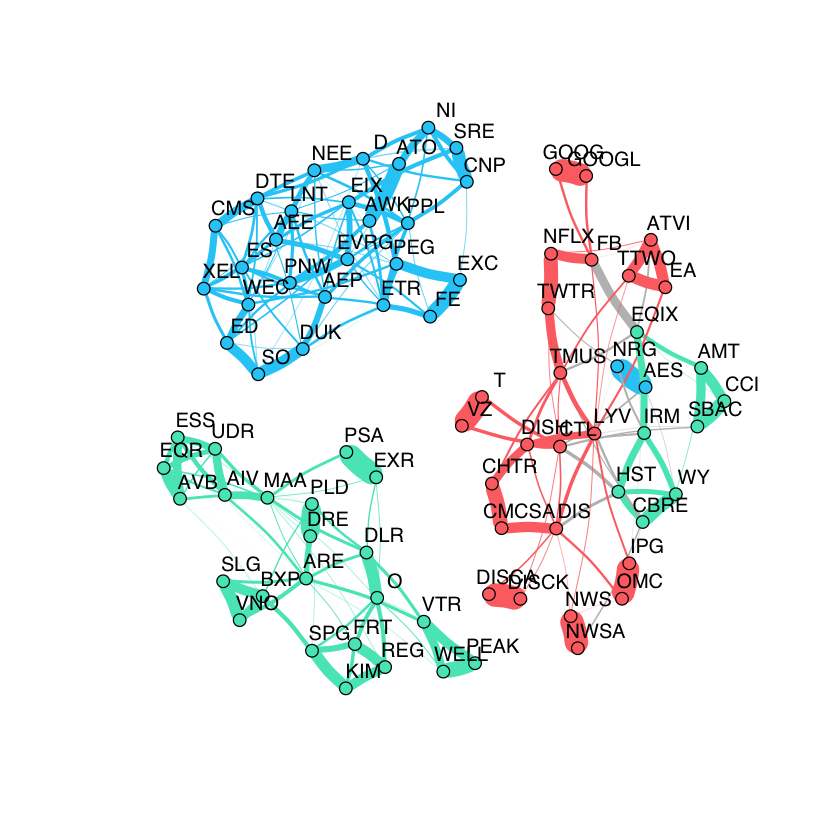

In [7]:
# plot network
net <- graph_from_adjacency_matrix(graph_mrf$adjacency,
                                   mode = "undirected",
                                   weighted = TRUE)
la_kcomp <- layout_nicely(net)
V(net)$label.cex = 1
colors <- c("#FD7272", "#55E6C1", "#25CCF7")
V(net)$color <- colors[stock_sectors_index]
V(net)$type <- stock_sectors_index
V(net)$cluster <- stock_sectors_index
E(net)$color <- apply(as.data.frame(get.edgelist(net)), 1,
                      function(x) ifelse(V(net)$cluster[x[1]] == V(net)$cluster[x[2]],
                                        colors[V(net)$cluster[x[1]]], 'grey'))
plot(net, vertex.label = colnames(stock_prices),
     layout = la_kcomp,
     vertex.size = 4.5,
     vertex.label.family = "Helvetica",
     vertex.label.dist = 1.25,
     vertex.label.color = "black",
     vertex.shape = "circle",
     edge.width = 20*E(net)$weight,
     edge.curved = 0.1)